In [358]:
from pyspark import SparkConf,SparkContext
from pyspark import mllib as ml
from pyspark.ml.feature import Tokenizer,HashingTF,IDF,StopWordsRemover,CountVectorizer
from pyspark.sql import SparkSession,SQLContext,Row
from pyspark.sql.functions import lower,regexp_replace,trim,split,avg,stddev
import string
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType,ArrayType,DoubleType,FloatType
from pyspark.mllib.linalg import VectorUDT,Vectors

In [ ]:
conf= SparkConf().setMaster("local").setAppName("Exam")
sc = SparkContext(conf=conf)

In [360]:
spark = SparkSession(sc)

In [361]:
sqlcontext = SQLContext(sc)

In [362]:
data = spark.read.csv("C:/Users/sugan/Desktop/gun-violence-data_01-2013_03-2018.csv",header=True)

In [363]:
data.columns

['incident_id',
 'date',
 'state',
 'city_or_county',
 'address',
 'n_killed',
 'n_injured',
 'incident_url',
 'source_url',
 'incident_url_fields_missing',
 'congressional_district',
 'gun_stolen',
 'gun_type',
 'incident_characteristics',
 'latitude',
 'location_description',
 'longitude',
 'n_guns_involved',
 'notes',
 'participant_age',
 'participant_age_group',
 'participant_gender',
 'participant_name',
 'participant_relationship',
 'participant_status',
 'participant_type',
 'sources',
 'state_house_district',
 'state_senate_district']

In [364]:
#Q1
data.groupby('state').agg({'incident_id':'count'}).sort('count(incident_id)',ascending=False).show(5)

+----------+------------------+
|     state|count(incident_id)|
+----------+------------------+
|  Illinois|             17556|
|California|             16306|
|   Florida|             15029|
|     Texas|             13577|
|      Ohio|             10244|
+----------+------------------+
only showing top 5 rows



In [365]:
data.registerTempTable("mytable")

In [366]:
data = data.withColumn('year',split(data['date'],'-')[0])

In [367]:
#Q2
data.groupby('year').agg({'incident_id':'count'}).sort('count(incident_id)',ascending=False).show(5)

+----+------------------+
|year|count(incident_id)|
+----+------------------+
|2017|             61401|
|2016|             58763|
|2015|             53579|
|2014|             51854|
|2018|             13802|
+----+------------------+
only showing top 5 rows



In [368]:
#Q3
#KMeans clustering

from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.clustering import KMeans
from pyspark.ml.clustering import KMeans as KM

In [369]:
kmeans = KM().setK(4).setSeed(1)

In [418]:
dataset = data.select('latitude','longitude')

In [419]:
dataset.show(5)

+--------+---------+
|latitude|longitude|
+--------+---------+
| 40.3467| -79.8559|
|  33.909| -118.333|
| 41.4455| -82.1377|
| 39.6518| -104.802|
|  36.114| -79.9569|
+--------+---------+
only showing top 5 rows



In [420]:
dataset = dataset.withColumn("latitude", dataset["latitude"].cast(FloatType()))
dataset = dataset.withColumn("longitude", dataset["longitude"].cast(FloatType()))

In [421]:
dataset = dataset.dropna()

In [422]:
# as_prob = udf(lambda x: DenseVector(x), VectorUDT())

# dataset= dataset.withColumn("latitude", as_prob(dataset["latitude"]))
# dataset= dataset.withColumn("longitude", as_prob(dataset["longitude"]))

In [423]:
from pyspark.ml.feature import StandardScaler

In [424]:
assembler = VectorAssembler(
    inputCols=["latitude", "longitude"],
    outputCol="features")

In [425]:
data_final = assembler.transform(dataset=dataset)

In [426]:
data_final.show(5)
data_final = data_final.drop('latitude','longitude')

+--------+---------+--------------------+
|latitude|longitude|            features|
+--------+---------+--------------------+
| 40.3467| -79.8559|[40.3466987609863...|
|  33.909| -118.333|[33.9090003967285...|
| 41.4455| -82.1377|[41.4454994201660...|
| 39.6518| -104.802|[39.6517982482910...|
|  36.114| -79.9569|[36.1139984130859...|
+--------+---------+--------------------+
only showing top 5 rows



In [427]:
scale = StandardScaler(inputCol='features',outputCol='scaledfeatures')

In [428]:
fit = scale.fit(data_final)

In [429]:
model_data = fit.transform(data_final).drop('features')

In [442]:
import matplotlib.pyplot as plt
%matplotlib inline

In [433]:
Kmean = KM(k=4,maxIter=400,seed=1,featuresCol='scaledfeatures')

In [416]:
test = model_data[0][1]

In [434]:
model = Kmean.fit(model_data)

In [435]:
wssse = model.computeCost(model_data)
print("Within Set Sum of Squared Errors = " + str(wssse))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 135931.75679442726
Cluster Centers: 
[ 7.66587272 -8.2389716 ]
[ 7.99388422 -5.70637296]
[ 5.72123908 -6.15186387]
[ 6.77571467 -6.00755338]


In [449]:
prediction = model.transform(model_data).drop('scaledfeatures')

In [458]:
pred = prediction.toPandas()['prediction'].values

['blue', 'orange', 'blue', 'orange', 'green', 'green', 'orange', 'purple', 'orange', 'blue']


C:\Users\sugan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


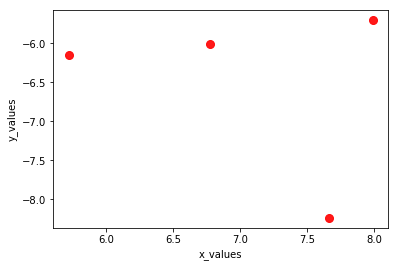

In [460]:
colors=['orange','blue','purple','green']
colored=[colors[k] for k in pred]
print(colored[0:10])
# plt.scatter(tocluster[4],tocluster[1],color=colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o',markersize=8, color='red', alpha=0.9)
    
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()